# Install libraries and dependencies

In [1]:

%pip install scikit-image scikit-learn matplotlib tqdm seaborn imbalanced-learn

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm # visualize iterations

DATASET_PATH = '../train_data'    # place data here
IMAGE_SIZE = (128, 128)     # resize images
MAX_IMAGES_PER_CLASS = 1000 # set hard limit to max images

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 3.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Load images from directory

In [2]:
from skimage.color import rgb2hsv, hsv2rgb

def load_images_and_labels(path, saturate=False, saturation_factor=2.0):
    X, y = [], []
    classes = sorted(os.listdir(path))
    for label in tqdm(classes):
        class_dir = os.path.join(path, label)
        if not os.path.isdir(class_dir):
            continue
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = imread(img_path)
                img = resize(img, IMAGE_SIZE, anti_aliasing=True)

                if img.ndim == 2:  # convert grayscale to RGB, if needed
                    img = np.stack([img]*3, axis=-1)

                if saturate:
                    img_hsv = rgb2hsv(img)
                    # increase saturation by a default of 2x
                    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] * saturation_factor, 0, 1)
                    img = hsv2rgb(img_hsv)

                X.append(img)
                y.append(label)
            except:
                continue

    return np.array(X), np.array(y)

X, y = load_images_and_labels(DATASET_PATH, saturate=True, saturation_factor=2.0)

NameError: name 'os' is not defined

In [ ]:
unique_classes, class_counts = np.unique(y, return_counts=True)
print("Class distribution in full dataset:")
for cls, count in zip(unique_classes, class_counts):
  print(f"{cls}: {count}")

Class distribution in full dataset:
Blight: 924
Common_Rust: 1043
Gray_Leaf_Spot: 457
Healthy: 929


# Extract HOG features

We identify the HOG features so that we can later pass them into the SVM classifier.

In [ ]:

from skimage.feature import hog

def extract_hog_features(images):
    features = []
    for img in tqdm(images, desc="Extracting HOG features"): # tqdm to see "progress"
        if img.ndim == 3 and img.shape[2] == 3:
            hog_feats = []
            for c in range(3):
                hog_feat = hog(img[..., c], orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
                hog_feats.append(hog_feat)
            hog_feat = np.concatenate(hog_feats)
        else:
            hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feat)
    return np.array(features)

X_hog = extract_hog_features(X)

Extracting HOG features: 100%|██████████| 3353/3353 [01:19<00:00, 42.12it/s]


# Encode labels and split data

In [ ]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# HOG features are turned into train/test data
X_train, X_test, y_train, y_test = train_test_split(X_hog, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train SVM classifier

In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# TO-DO: address class imbalances
classifier = SVC(kernel='rbf')
classifier.fit(X_train, y_train)

SVC()

# Generate the classification report

In [ ]:

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Blight       0.71      0.83      0.76       185
   Common_Rust       1.00      0.92      0.96       209
Gray_Leaf_Spot       0.80      0.35      0.49        91
       Healthy       0.78      0.94      0.85       186

      accuracy                           0.82       671
     macro avg       0.82      0.76      0.77       671
  weighted avg       0.83      0.82      0.81       671



# Generate the confusion matrix

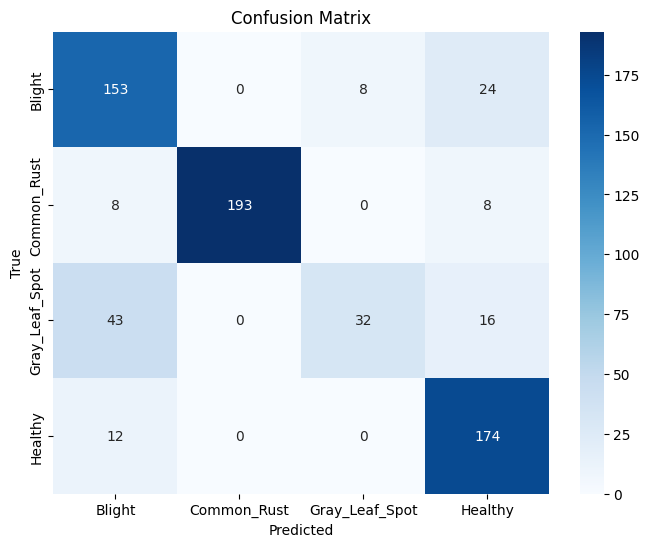

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model and label encoder

In [ ]:

import joblib
joblib.dump(classifier, 'svm_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']